<a href="https://colab.research.google.com/github/murakamixi/suumo_cnn_tensorflow/blob/train_cmm/fine_turning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
classes = ['bathroom', 'genkan', 'kitchen', 'mitorizu', 'senmenjo', 'wc',]
nb_classes = len(classes)

img_width, img_height = 64, 64

#traning and validation data dir
train_data_dir = './data/train'
validation_data_dir = './data/validation'

nb_train_samples = 81
nb_validation_samples = 81

batch_size = 16
nb_epoch = 10

In [ ]:
# トレーンング用、バリデーション用データを生成するジェネレータ作成
train_datagen = ImageDataGenerator(
  rescale=1.0 / 255,
  zoom_range=0.2,
  horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

Found 81 images belonging to 6 classes.
Found 81 images belonging to 6 classes.


In [ ]:
from keras.models import Model
from keras import optimizers
from keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16
import os


# VGG16のロード。FC層は不要なので include_top=False
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# FC層の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes, activation='softmax'))

# VGG16とFC層を結合してモデルを作成
vgg_model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# 最後のconv層の直前までの層をfreeze
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
            metrics=['accuracy'])

In [ ]:
result_dir = './result'
# Fine-tuning
history = vgg_model.fit_generator(
    generator=train_generator,
    # samples_per_epoch=nb_train_samples,
    epochs=nb_epoch,
    validation_data=validation_generator,
    # nb_val_samples=nb_validation_samples
    )

# 重みを保存
vgg_model.save_weights(os.path.join(result_dir, 'finetuning.h5'))

/Users/m.kazu/opt/anaconda3/envs/suumo_tensor_py39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
6/6 [==============================] - 5s 661ms/step - loss: 2.0050 - accuracy: 0.1514 - val_loss: 1.4715 - val_accuracy: 0.5309
Epoch 2/10
6/6 [==============================] - 4s 771ms/step - loss: 1.7394 - accuracy: 0.3009 - val_loss: 1.2330 - val_accuracy: 0.6173
Epoch 3/10
6/6 [==============================] - 4s 652ms/step - loss: 1.4845 - accuracy: 0.4726 - val_loss: 1.3260 - val_accuracy: 0.4074
Epoch 4/10
6/6 [==============================] - 5s 974ms/step - loss: 1.3271 - accuracy: 0.3871 - val_loss: 1.1552 - val_accuracy: 0.5185
Epoch 5/10
6/6 [==============================] - 6s 1s/step - loss: 1.2701 - accuracy: 0.5370 - val_loss: 0.9812 - val_accuracy: 0.7284
Epoch 6/10
6/6 [==============================] - 6s 1s/step - loss: 1.1635 - accuracy: 0.5806 - val_loss: 0.9976 - val_accuracy: 0.5802
Epoch 7/10
6/6 [==============================] - 6s 982ms/step - loss: 1.2828 - accuracy: 0.5143 - val_loss: 1.0209 - val_accuracy: 0.5556
Epoch 8/10
6/6 [==========

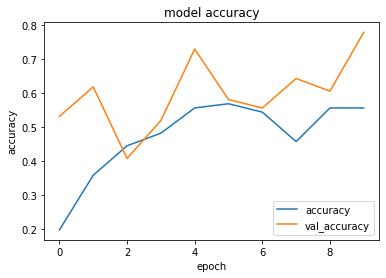

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()